# Phase 2: Feature Engineering - Enhanced Spectral Indices

This notebook computes enhanced Landsat spectral indices beyond the baseline NDMI and MNDWI.

## Objectives
1. Load Landsat training and validation data
2. Compute additional spectral indices relevant to water quality
3. Create band ratios and transformations
4. Save enhanced feature datasets

## Available Bands
- **NIR** (Near Infrared): Vegetation and water detection
- **Green**: Water color and surface reflectance
- **SWIR16** (Shortwave Infrared 1): Surface dryness, sediment
- **SWIR22** (Shortwave Infrared 2): Surface moisture, turbidity


## Step 1: Load Dependencies and Data


In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load Landsat training data
print("Loading Landsat training data...")
landsat_train = pd.read_csv('landsat_features_training.csv')
print(f"Training data shape: {landsat_train.shape}")
print(f"Columns: {list(landsat_train.columns)}")
print("\nFirst few rows:")
landsat_train.head()


Loading Landsat training data...
Training data shape: (9319, 9)
Columns: ['Latitude', 'Longitude', 'Sample Date', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI']

First few rows:


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-28.760833,17.730278,02-01-2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595
1,-26.861111,28.884722,03-01-2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134
2,-26.450000,28.085833,03-01-2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805
3,-27.671111,27.236944,03-01-2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416
4,-27.356667,27.286389,03-01-2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683


In [3]:
# Load Landsat validation data (if available)
try:
    landsat_val = pd.read_csv('landsat_features_validation.csv')
    print(f"Validation data shape: {landsat_val.shape}")
    print("Validation data loaded successfully.")
except FileNotFoundError:
    print("Validation data not found. Will process training data only.")
    landsat_val = None


Validation data shape: (200, 9)
Validation data loaded successfully.


## Step 2: Compute Enhanced Spectral Indices

### 2.1 Vegetation and Water Indices

We'll compute indices that are relevant for water quality prediction:

1. **NDVI** (Normalized Difference Vegetation Index): Vegetation health
2. **NDWI** (Normalized Difference Water Index): Water body detection
3. **NDSI_water** (Normalized Difference Snow/Water Index): Water vs. land
4. **NDTI** (Normalized Difference Turbidity Index): Water turbidity
5. **Turbidity Index**: Suspended sediment indicator
6. **Chlorophyll-a Proxy**: Algal bloom indicator
7. **BSI** (Bare Soil Index): Soil exposure indicator


In [4]:
def compute_spectral_indices(df, epsilon=1e-10):
    """
    Compute enhanced spectral indices from Landsat bands.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing Landsat bands (nir, green, swir16, swir22)
    epsilon : float
        Small value to prevent division by zero
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional spectral indices
    """
    df = df.copy()
    
    # Extract bands (handle missing values)
    nir = df['nir'].values
    green = df['green'].values
    swir16 = df['swir16'].values
    swir22 = df['swir22'].values
    
    # ============================================
    # 1. VEGETATION INDICES
    # ============================================
    
    # NDVI: Normalized Difference Vegetation Index
    # Formula: (NIR - Green) / (NIR + Green)
    # Range: -1 to 1, higher = more vegetation
    # Relevance: Vegetation affects runoff and water quality
    df['NDVI'] = (nir - green) / (nir + green + epsilon)
    df['NDVI'] = df['NDVI'].clip(-1, 1)
    
    # ============================================
    # 2. WATER INDICES
    # ============================================
    
    # NDWI: Normalized Difference Water Index (McFeeters, 1996)
    # Formula: (Green - NIR) / (Green + NIR)
    # Range: -1 to 1, higher = more water
    # Relevance: Direct water body detection
    df['NDWI'] = (green - nir) / (green + nir + epsilon)
    df['NDWI'] = df['NDWI'].clip(-1, 1)
    
    # NDSI_water: Normalized Difference Snow/Water Index (for water)
    # Formula: (Green - SWIR22) / (Green + SWIR22)
    # Range: -1 to 1, higher = more water
    # Relevance: Water detection, less affected by built-up areas than MNDWI
    df['NDSI_water'] = (green - swir22) / (green + swir22 + epsilon)
    df['NDSI_water'] = df['NDSI_water'].clip(-1, 1)
    
    # ============================================
    # 3. TURBIDITY AND SEDIMENT INDICES
    # ============================================
    
    # NDTI: Normalized Difference Turbidity Index
    # Formula: (SWIR22 - Green) / (SWIR22 + Green)
    # Range: -1 to 1, higher = more turbid
    # Relevance: Suspended sediment affects water quality
    df['NDTI'] = (swir22 - green) / (swir22 + green + epsilon)
    df['NDTI'] = df['NDTI'].clip(-1, 1)
    
    # Turbidity Index (Lacaux et al., 2007)
    # Formula: SWIR22 / Green
    # Range: > 0, higher = more turbid
    # Relevance: Direct turbidity measurement
    df['Turbidity_Index'] = swir22 / (green + epsilon)
    
    # ============================================
    # 4. CHLOROPHYLL AND ALGAL INDICES
    # ============================================
    
    # Chlorophyll-a Proxy (Gitelson et al., 2007)
    # Formula: (NIR / Green) - 1
    # Range: > -1, higher = more chlorophyll
    # Relevance: Algal blooms affect DRP and water quality
    df['Chlorophyll_Proxy'] = (nir / (green + epsilon)) - 1
    
    # ============================================
    # 5. SOIL AND MOISTURE INDICES
    # ============================================
    
    # BSI: Bare Soil Index (Rikimaru et al., 2002)
    # Formula: ((SWIR22 + SWIR16) - (NIR + Green)) / ((SWIR22 + SWIR16) + (NIR + Green))
    # Range: -1 to 1, higher = more bare soil
    # Relevance: Soil erosion affects water quality
    df['BSI'] = ((swir22 + swir16) - (nir + green)) / ((swir22 + swir16) + (nir + green) + epsilon)
    df['BSI'] = df['BSI'].clip(-1, 1)
    
    # ============================================
    # 6. BAND RATIOS (Important for water quality)
    # ============================================
    
    # SWIR22/NIR ratio: Moisture and turbidity indicator
    df['SWIR22_NIR_ratio'] = swir22 / (nir + epsilon)
    
    # SWIR16/NIR ratio: Surface dryness indicator
    df['SWIR16_NIR_ratio'] = swir16 / (nir + epsilon)
    
    # Green/NIR ratio: Vegetation and water indicator
    df['Green_NIR_ratio'] = green / (nir + epsilon)
    
    # SWIR22/Green ratio: Turbidity and sediment indicator
    df['SWIR22_Green_ratio'] = swir22 / (green + epsilon)
    
    # SWIR16/Green ratio: Surface condition indicator
    df['SWIR16_Green_ratio'] = swir16 / (green + epsilon)
    
    # ============================================
    # 7. LOG TRANSFORMATIONS (Handle skewed distributions)
    # ============================================
    
    # Log transforms of bands (add 1 to handle zeros)
    df['log_nir'] = np.log1p(nir)
    df['log_green'] = np.log1p(green)
    df['log_swir16'] = np.log1p(swir16)
    df['log_swir22'] = np.log1p(swir22)
    
    # ============================================
    # 8. SQUARED TERMS (Non-linear relationships)
    # ============================================
    
    # Squared terms for key bands
    df['nir_squared'] = nir ** 2
    df['swir22_squared'] = swir22 ** 2
    
    return df


In [5]:
# Apply spectral index computation to training data
print("Computing enhanced spectral indices for training data...")
print(f"Original columns: {len(landsat_train.columns)}")

landsat_train_enhanced = compute_spectral_indices(landsat_train)

print(f"\nEnhanced columns: {len(landsat_train_enhanced.columns)}")
print(f"New indices added: {len(landsat_train_enhanced.columns) - len(landsat_train.columns)}")
print("\nNew columns:")
new_cols = [col for col in landsat_train_enhanced.columns if col not in landsat_train.columns]
print(new_cols)


Computing enhanced spectral indices for training data...
Original columns: 9

Enhanced columns: 27
New indices added: 18

New columns:
['NDVI', 'NDWI', 'NDSI_water', 'NDTI', 'Turbidity_Index', 'Chlorophyll_Proxy', 'BSI', 'SWIR22_NIR_ratio', 'SWIR16_NIR_ratio', 'Green_NIR_ratio', 'SWIR22_Green_ratio', 'SWIR16_Green_ratio', 'log_nir', 'log_green', 'log_swir16', 'log_swir22', 'nir_squared', 'swir22_squared']


In [6]:
# Apply spectral index computation to validation data (if available)
if landsat_val is not None:
    print("Computing enhanced spectral indices for validation data...")
    landsat_val_enhanced = compute_spectral_indices(landsat_val)
    print(f"Validation data enhanced. Shape: {landsat_val_enhanced.shape}")
else:
    print("Skipping validation data (not available).")


Computing enhanced spectral indices for validation data...
Validation data enhanced. Shape: (200, 27)


## Step 3: Explore New Indices


In [7]:
# Summary statistics for new indices
print("Summary Statistics for New Spectral Indices:\n")
print(landsat_train_enhanced[new_cols].describe())


Summary Statistics for New Spectral Indices:

              NDVI         NDWI   NDSI_water         NDTI  Turbidity_Index  \
count  8234.000000  8234.000000  8234.000000  8234.000000      8234.000000   
mean      0.165185    -0.165185    -0.062930     0.062930         1.149728   
std       0.087471     0.087471     0.082061     0.082061         0.177772   
min      -0.377415    -0.456681    -0.277188    -0.554247         0.286796   
25%       0.127845    -0.216825    -0.120870     0.020585         1.042036   
50%       0.173159    -0.173159    -0.071915     0.071915         1.154976   
75%       0.216825    -0.127845    -0.020585     0.120870         1.274975   
max       0.456681     0.377415     0.554247     0.277188         1.766972   

       Chlorophyll_Proxy          BSI  SWIR22_NIR_ratio  SWIR16_NIR_ratio  \
count        8234.000000  8234.000000       8234.000000       8234.000000   
mean            0.420682     0.013811          0.823460          0.969510   
std             0.24

In [8]:
# Check for missing values in new indices
print("Missing values in new indices:\n")
missing = landsat_train_enhanced[new_cols].isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")


Missing values in new indices:

NDVI                  1085
NDWI                  1085
NDSI_water            1085
NDTI                  1085
Turbidity_Index       1085
Chlorophyll_Proxy     1085
BSI                   1085
SWIR22_NIR_ratio      1085
SWIR16_NIR_ratio      1085
Green_NIR_ratio       1085
SWIR22_Green_ratio    1085
SWIR16_Green_ratio    1085
log_nir               1085
log_green             1085
log_swir16            1085
log_swir22            1085
nir_squared           1085
swir22_squared        1085
dtype: int64


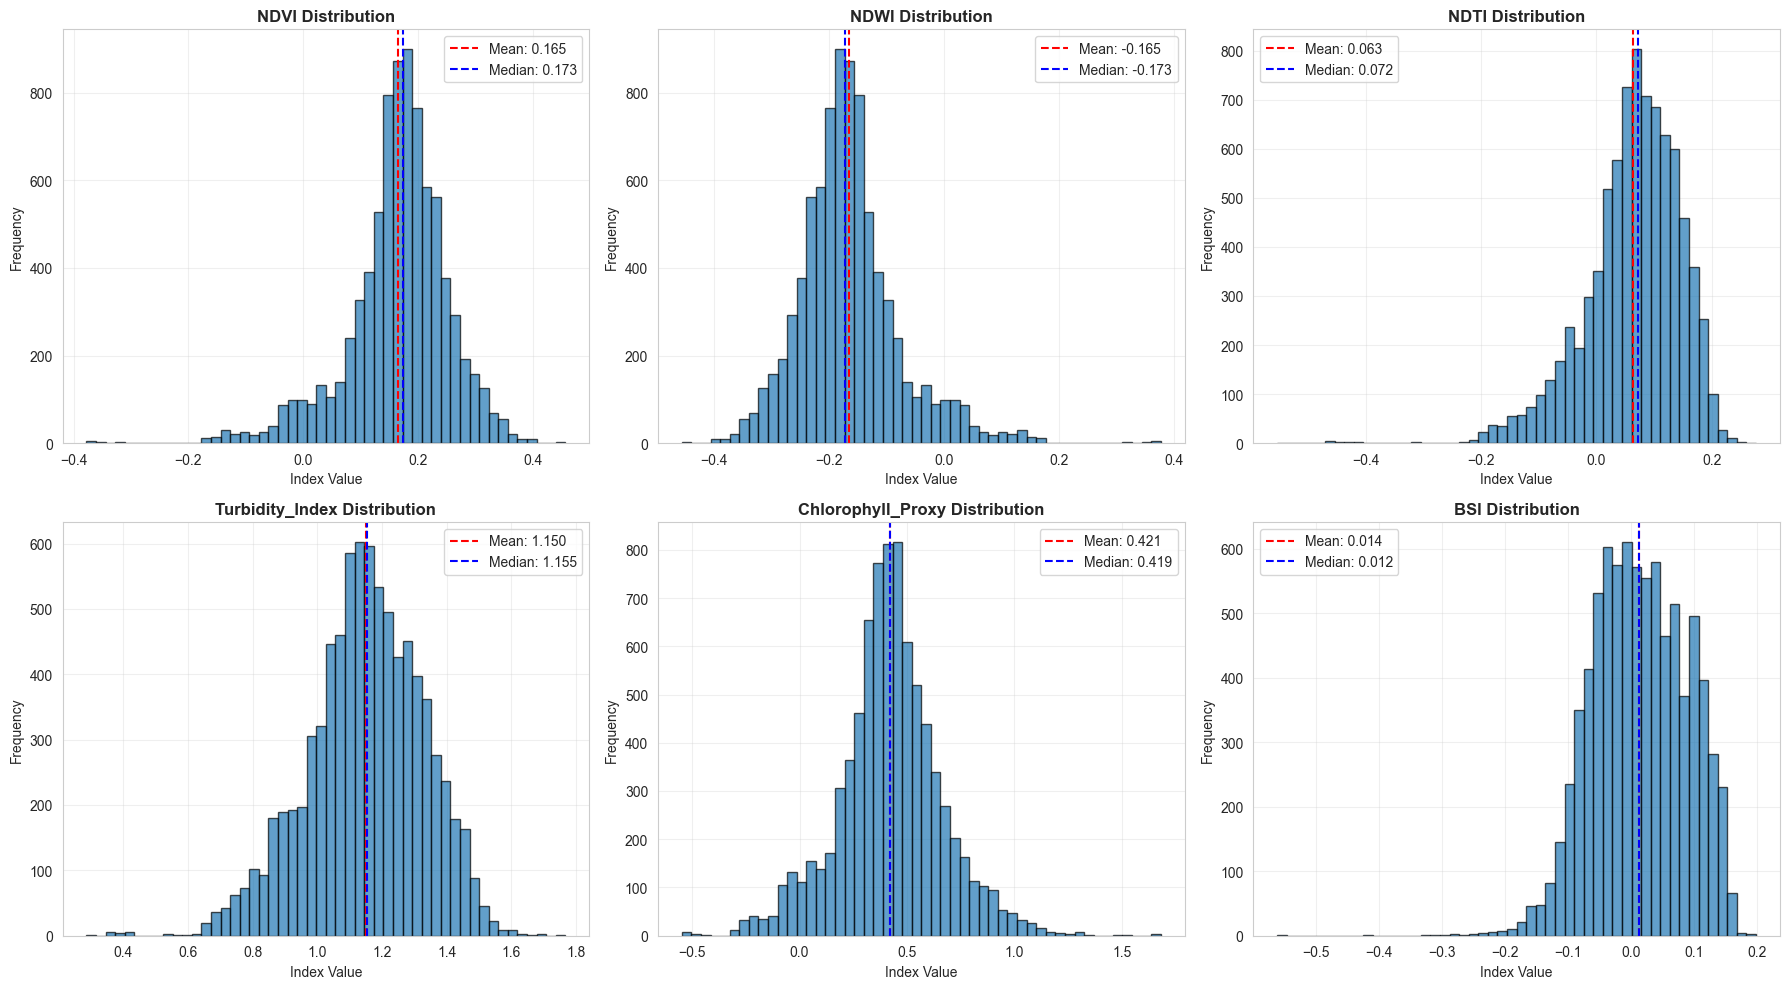

In [9]:
# Visualize distributions of key new indices
key_indices = ['NDVI', 'NDWI', 'NDTI', 'Turbidity_Index', 'Chlorophyll_Proxy', 'BSI']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, index_name in enumerate(key_indices):
    if index_name in landsat_train_enhanced.columns:
        data = landsat_train_enhanced[index_name].dropna()
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{index_name} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Index Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
        axes[idx].axvline(median_val, color='blue', linestyle='--', label=f'Median: {median_val:.3f}')
        axes[idx].legend()

plt.tight_layout()
plt.savefig('spectral_indices_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


Correlation Matrix: New Indices vs. Existing Indices



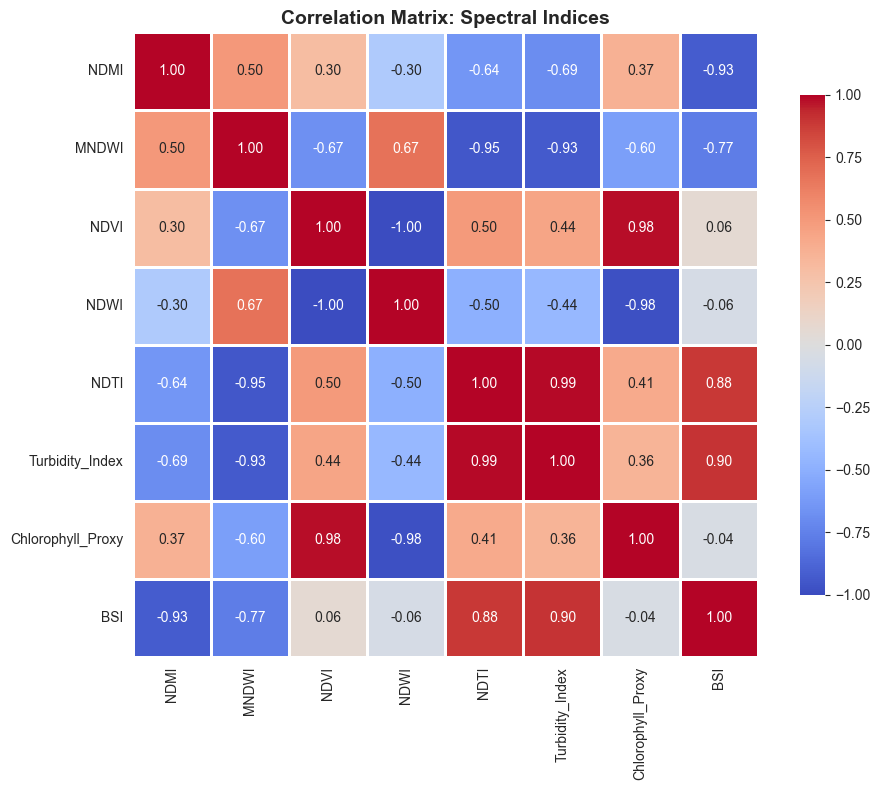

In [10]:
# Correlation between new indices and existing ones
print("Correlation Matrix: New Indices vs. Existing Indices\n")

existing_indices = ['NDMI', 'MNDWI']
new_indices_corr = ['NDVI', 'NDWI', 'NDTI', 'Turbidity_Index', 'Chlorophyll_Proxy', 'BSI']

# Create correlation matrix
corr_data = landsat_train_enhanced[existing_indices + new_indices_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Spectral Indices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('spectral_indices_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 4: Save Enhanced Datasets


In [11]:
# Save enhanced training dataset
output_file_train = 'landsat_features_training_enhanced.csv'
landsat_train_enhanced.to_csv(output_file_train, index=False)
print(f"Enhanced training dataset saved to: {output_file_train}")
print(f"Shape: {landsat_train_enhanced.shape}")
print(f"\nColumns ({len(landsat_train_enhanced.columns)}):")
for i, col in enumerate(landsat_train_enhanced.columns, 1):
    print(f"{i:2d}. {col}")


Enhanced training dataset saved to: landsat_features_training_enhanced.csv
Shape: (9319, 27)

Columns (27):
 1. Latitude
 2. Longitude
 3. Sample Date
 4. nir
 5. green
 6. swir16
 7. swir22
 8. NDMI
 9. MNDWI
10. NDVI
11. NDWI
12. NDSI_water
13. NDTI
14. Turbidity_Index
15. Chlorophyll_Proxy
16. BSI
17. SWIR22_NIR_ratio
18. SWIR16_NIR_ratio
19. Green_NIR_ratio
20. SWIR22_Green_ratio
21. SWIR16_Green_ratio
22. log_nir
23. log_green
24. log_swir16
25. log_swir22
26. nir_squared
27. swir22_squared


In [12]:
# Save enhanced validation dataset (if available)
if landsat_val is not None and 'landsat_val_enhanced' in locals():
    output_file_val = 'landsat_features_validation_enhanced.csv'
    landsat_val_enhanced.to_csv(output_file_val, index=False)
    print(f"Enhanced validation dataset saved to: {output_file_val}")
    print(f"Shape: {landsat_val_enhanced.shape}")
else:
    print("Validation dataset not processed.")


Enhanced validation dataset saved to: landsat_features_validation_enhanced.csv
Shape: (200, 27)


## Summary

### Indices Computed:

**Vegetation & Water:**
- NDVI: Vegetation health indicator
- NDWI: Water body detection
- NDSI_water: Water vs. land discrimination

**Turbidity & Sediment:**
- NDTI: Normalized difference turbidity index
- Turbidity_Index: Direct turbidity measurement

**Chlorophyll & Algae:**
- Chlorophyll_Proxy: Algal bloom indicator

**Soil & Surface:**
- BSI: Bare soil index

**Band Ratios:**
- SWIR22/NIR, SWIR16/NIR, Green/NIR
- SWIR22/Green, SWIR16/Green

**Transformations:**
- Log transforms of all bands
- Squared terms for key bands

### Next Steps:
- Phase 2, Step 3: Extract additional TerraClimate variables
- Phase 2, Step 4: Extract spatial features (elevation, land cover)
- Phase 2, Step 5: Create temporal features
- Phase 2, Step 6: Combine all features
